In [1]:
!pip install pmdarima


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
stock_data = pd.read_csv('train.csv', sep=';').fillna(0)
stock_data['<DATE>'] = pd.to_datetime(stock_data['<DATE>'], format='%y%m%d')

stock_data.head()  # Check the first few rows to verify the data

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SBER,D,2023-05-02,0,242.20,245.00,237.40,242.62,83246880
1,SBER,D,2023-05-03,0,242.85,242.99,234.00,235.77,76740930
2,SBER,D,2023-05-04,0,236.51,239.74,236.05,238.89,53006840
3,SBER,D,2023-05-05,0,239.19,240.66,237.30,237.70,61314710
4,SBER,D,2023-05-08,0,238.65,239.86,237.36,238.27,47676110


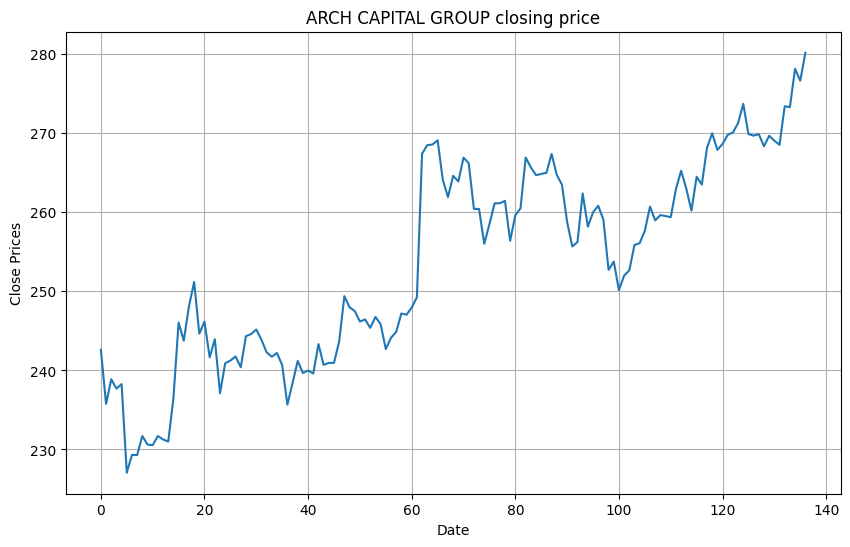

In [3]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['<CLOSE>'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

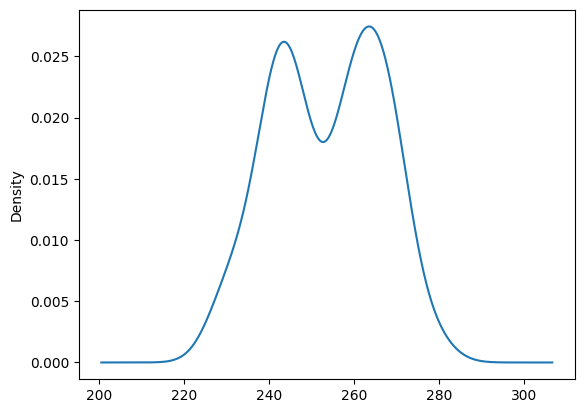

In [4]:
df_close = stock_data['<CLOSE>']
df_close.plot(kind='kde')

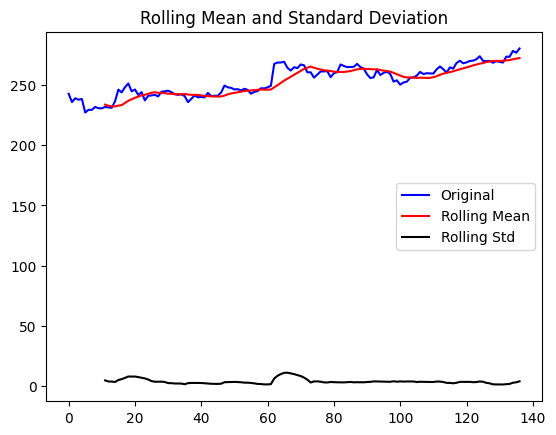

Results of dickey fuller test
Test Statistics                 -0.944966
p-value                          0.772804
No. of lags used                 0.000000
Number of observations used    136.000000
critical value (1%)             -3.479372
critical value (5%)             -2.883037
critical value (10%)            -2.578234
dtype: float64


In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


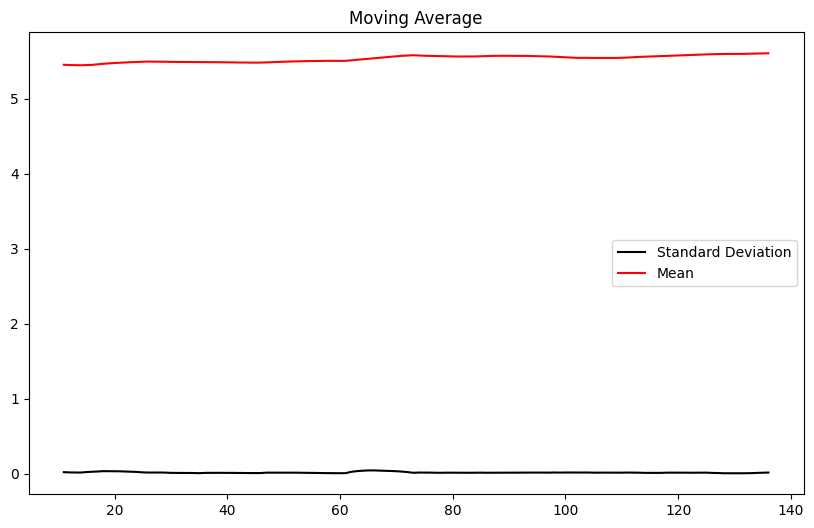

In [6]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


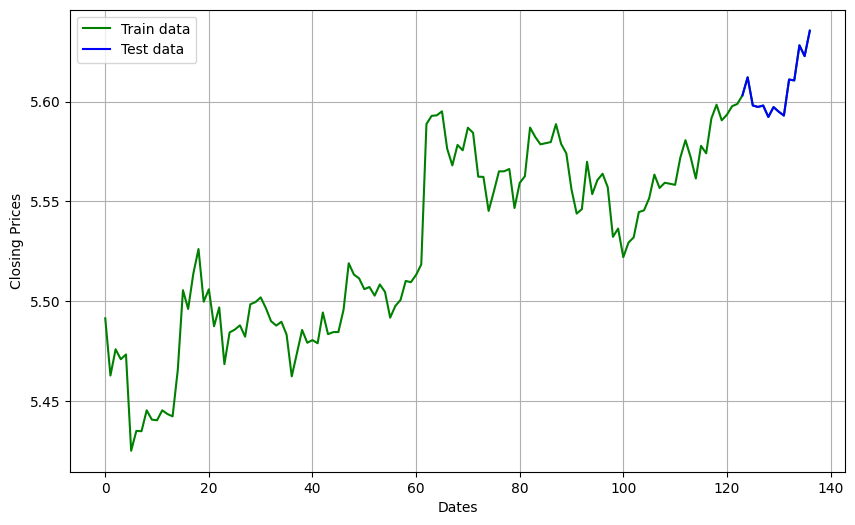

In [7]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-681.872, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-680.761, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-680.696, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-683.128, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-678.723, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.196 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 342.564
Date:                Sun, 26 Nov 2023   AIC                           -683.128
Time:                        19:17:09   BIC                           -680.349
Sample:                             0   HQIC                          -682.000
                                - 120                                       

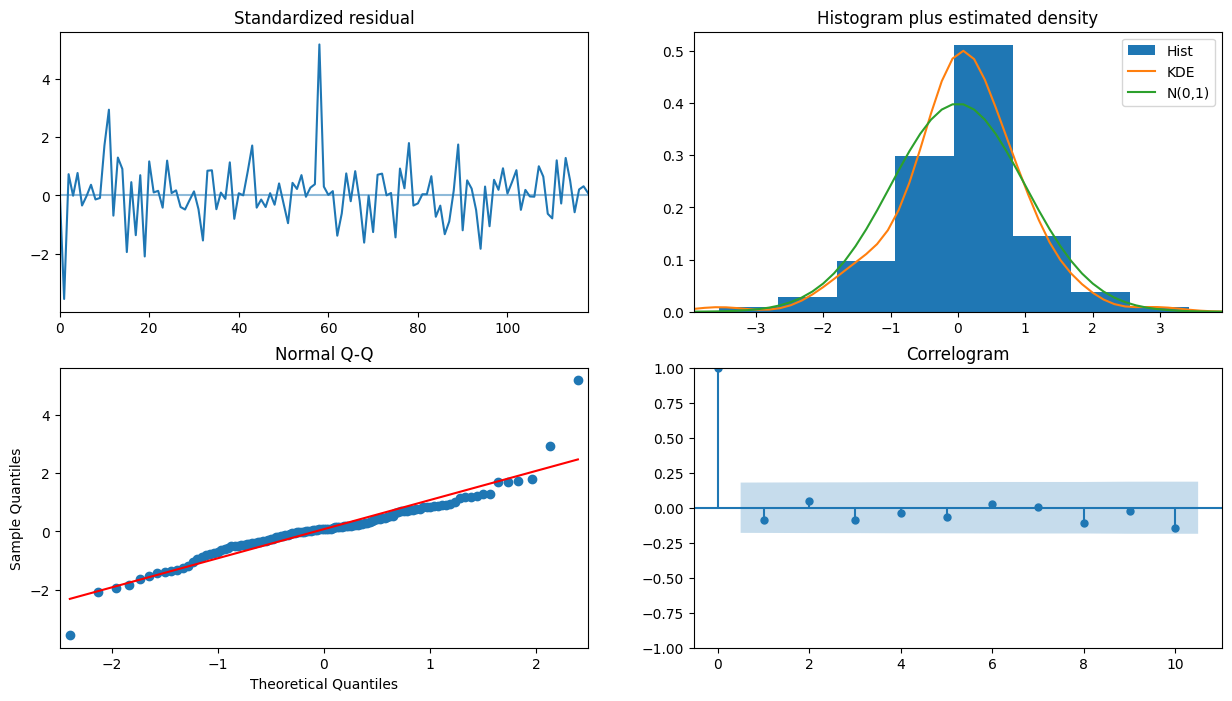

In [8]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [9]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming you have your 'train_data' as a pandas Series or DataFrame

# Build and fit the SARIMAX model
order = (1, 1, 2)  # Replace with your desired order
model = SARIMAX(train_data, order=order)
fitted = model.fit(disp=-1)
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                <CLOSE>   No. Observations:                  120
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 342.887
Date:                Sun, 26 Nov 2023   AIC                           -677.774
Time:                        19:17:09   BIC                           -666.657
Sample:                             0   HQIC                          -673.260
                                - 120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2707      1.749      0.155      0.877      -3.158       3.699
ma.L1         -0.3280      1.752     -0.187      0.851      -3.762       3.106
ma.L2          0.0706      0.142      0.498      0.6

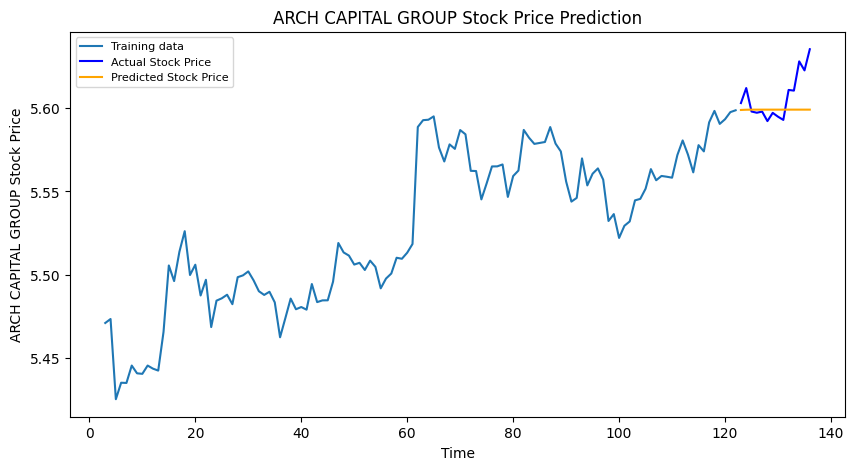

In [10]:
# Forecast
steps = 321  # Number of steps to forecast
forecast = fitted.forecast(steps, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(forecast, index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')

# Confidence interval (if available)
if len(forecast) > steps:
    lower_series = pd.Series(forecast[steps:, 0], index=test_data.index)
    upper_series = pd.Series(forecast[steps:, 1], index=test_data.index)
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)

plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
